In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
import gc
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '/home/tgeorgiopoulos/Downloads'

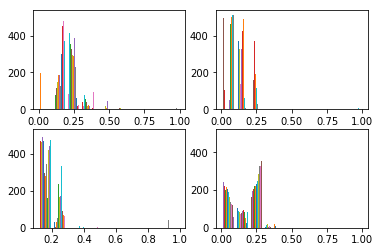

In [3]:
img1 = mpimg.imread(path+'/MURA-v1.1/train/XR_FINGER/patient03400/study1_positive/image2.png')
img2 = mpimg.imread(path+'/MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image2.png')
img3 = mpimg.imread(path+'/MURA-v1.1/train/XR_HAND/patient00051/study1_negative/image1.png')
img4 = mpimg.imread(path+'/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png')

plt.subplot(221); plt.hist(img1)
plt.subplot(222); plt.hist(img2)
plt.subplot(223); plt.hist(img3)
plt.subplot(224); plt.hist(img4)
plt.show()


The images have grayscale values between 0 and 1. So, there is no need for rescaling.

In [4]:
# Reading the images from csv and creating a panda frame with the paths and the labels for each image.
train_df = pd.read_csv(path+'/MURA-v1.1/train_image_paths.csv',names = ['paths','label'],
                       skiprows=9651, nrows=5106)
valid_df = pd.read_csv(path+'/MURA-v1.1/valid_image_paths.csv',names = ['paths','label'],
                       skiprows=2736, nrows=461)

for index, row in train_df.iterrows():
    if "positive" in train_df.iloc[index,0]:
        train_df.iloc[index,1] = 1
    elif "negative" in train_df.iloc[index,0]:
        train_df.iloc[index,1] = 0

for index, row in valid_df.iterrows():
    if "positive" in valid_df.iloc[index,0]:
        valid_df.iloc[index,1] = 1
    elif "negative" in valid_df.iloc[index,0]:
        valid_df.iloc[index,1] = 0

We apply data augmentation to the train dataset and convert all the images to (50,50) dimensions.

In [7]:
train_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization=True,
                                   rotation_range = 40, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1,
                                   zoom_range = 0.01, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=path,
                                                    x_col='paths',
                                                    y_col='label',
                                                    has_ext=True,
                                                    batch_size=8,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    target_size=(50,50),
                                                    color_mode='grayscale')

valid_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization = True,
                                   rotation_range = 0, 
                                   width_shift_range = 0., 
                                   height_shift_range = 0.,
                                   zoom_range = 0.0, 
                                   horizontal_flip = False,
                                   vertical_flip = False)

validation_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                                         directory=path,
                                                         x_col='paths',
                                                         y_col='label',
                                                         has_ext=True,
                                                         batch_size=8,
                                                         class_mode='binary',
                                                         shuffle=False,
                                                         target_size=(50,50),
                                                         color_mode='grayscale')

Found 5106 images belonging to 2 classes.
Found 461 images belonging to 2 classes.


In [17]:
model_conv = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size = (5,5), activation="relu",input_shape=(50, 50, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(4,4)),
        tf.keras.layers.Conv2D(256, kernel_size = (5,5), activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(4,4)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
model = multi_gpu_model(model_conv, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=5,
                              steps_per_epoch=500,
                              validation_data=validation_generator,
                              verbose=2)

In [ ]:
model_conv.summary()

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 150, 1)),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1, activation="softmax")])
model = multi_gpu_model(model, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=5,
                              validation_data=validation_generator,
                              verbose=1)

Epoch 1/5
511/511 [==============================] - 21s 41ms/step - loss: 10.9584 - acc: 0.3126 - val_loss: 5.1684 - val_acc: 0.6758
Epoch 2/5
511/511 [==============================] - 20s 39ms/step - loss: 10.9584 - acc: 0.3126 - val_loss: 5.1684 - val_acc: 0.6758
Epoch 3/5
511/511 [==============================] - 21s 41ms/step - loss: 10.9561 - acc: 0.3128 - val_loss: 5.1684 - val_acc: 0.6758
Epoch 4/5
511/511 [==============================] - 21s 41ms/step - loss: 10.9514 - acc: 0.3131 - val_loss: 5.1684 - val_acc: 0.6758
Epoch 5/5
511/511 [==============================] - 21s 41ms/step - loss: 10.9584 - acc: 0.3126 - val_loss: 5.1684 - val_acc: 0.6758


In [17]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50, 3))

In [18]:
model = tf.keras.models.Sequential([
        conv_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1, activation='softmax')])

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = multi_gpu_model(model, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=50,
                              validation_data=validation_generator)